In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback
from sklearn import preprocessing
from ucimlrepo import fetch_ucirepo 

import seaborn as sns

2024-08-04 21:29:49.822480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
dataset_name = "parkinsons"

In [5]:
# fetch dataset 
credit_approval = fetch_ucirepo(id=174) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 

{'uci_id': 174, 'name': 'Parkinsons', 'repository_url': 'https://archive.ics.uci.edu/dataset/174/parkinsons', 'data_url': 'https://archive.ics.uci.edu/static/public/174/data.csv', 'abstract': "Oxford Parkinson's Disease Detection Dataset", 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 197, 'num_features': 22, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['status'], 'index_col': ['name'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2007, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C59C74', 'creators': ['Max Little'], 'intro_paper': {'title': 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 'authors': 'Max A. Little, P. McSharry, S. Roberts, D. Costello, I. Moroz', 'published_in': 'BioMedical Engineering OnLine', 'year': 2007, 'url': 'https://www.semanticscholar.org/paper/27e1dcd0d64bfc9d936e597d4f29b8

In [6]:
categorical_cols = []
# One-hot encode the categorical columns
df_encoded = pd.get_dummies(X, columns=categorical_cols)
# Initialize a scaler
scaler = preprocessing.StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = X.fillna(0)
# to numpy
X = X.values

In [7]:
y = np.array([float(elem) for elem in y["status"]])

In [8]:
from sklearn import model_selection

In [9]:
X, Xtest, y, ytest = model_selection.train_test_split(X, y)

In [10]:
y.mean()

0.8013698630136986

In [11]:
ytest.sum()

30.0

## Specify learning algorithms

In [12]:
import math


def sigmoid(x):
    x = np.clip(x, -200, 200)
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    #print(f"{X=}")
    #print(f"{theta.T=}")
    #print(f"{y=}")
    y = sigmoid(y)
    #print(f"{y=}")
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-45):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    #print(f"{p=}")
    #print(f"{y=}")
    #print(f"{l=}")
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + np.exp(u)) ** 2) * np.log1p(np.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [13]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=1,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-45,
    max_iterations = 6600
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = min(X.shape[0], max_iterations)  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_random":
            """
            Added to address the reviewer's comment:
            The authors conduct experiments on "uniform sampling" + "constant step size", "loss-based sampling" + "constant step size", 
            and "loss-based sampling" + "Polyak step size" to verify the effectiveness of the approach of loss-based sampling. For 
            completeness, it is necessary to present the performance of using "uniform sampling" + "Polyak step size" in the numerical experiments.
            """
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = pz0
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        #print(f"{p=}")
        #print(f"{yy=}")
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        #print(f"{p=}")
        #print(f"{ytest=}")
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 10 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))} acc: {accuracies[i]}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [14]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [15]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [16]:
hyperparam_per_algo["absloss"] = {"eta": 0.01}
hyperparam_per_algo["random"] = {"eta": 0.01}
hyperparam_per_algo["polyak_absloss"] |= {
    "eta": 0.01,
    "kappa": 5,
    "kappa0": 0.9,
    "omega": 1.0
}
hyperparam_per_algo["polyak_exponent"] |= {
    "eta": 0.01,
    "kappa": 5,
    "kappa0": 0.9,
    "omega": 1.10
}

In [17]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 5, 'kappa0': 0.9, 'eta': 0.01, 'omega': 1.0},
 'polyak_exponent': {'kappa': 5,
  'kappa0': 0.9,
  'eta': 0.01,
  'polyakexp': 0.9951814804061615,
  'omega': 1.1},
 'absloss': {'eta': 0.01},
 'random': {'eta': 0.01}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [18]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 146 iterations with d=22
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6873115952687207, train loss: 0.7175363196739891, ||theta||_1: 0.1600766781625605 acc: 0.0
loss: 0.694129688641012, train loss: 0.7064685568728003, ||theta||_1: 0.2343703719974397 acc: 0.0
loss: 0.6838544064854246, train loss: 0.7229176470417442, ||theta||_1: 0.24649028970079304 acc: 0.0
loss: 0.6938551508566477, train loss: 0.6834475001807789, ||theta||_1: 0.29473464922532805 acc: 1.0
loss: 0.6584866931091233, train loss: 0.7664563655191307, ||theta||_1: 0.3929318445136175 acc: 0.0
loss: 0.6210162248868725, train loss: 0.7604646849233323, ||theta||_1: 0.4808026972922393 acc: 0.0
loss: 0.6497141618534896, train loss: 0.7525917406861825, ||theta||_1: 0.4630695791360513 acc: 0.0
loss: 0.6626592741927637, train loss: 0.7578530721141207, ||theta||_1: 0.455888538071363 acc: 0.0
loss: 0.6554085941401548, train loss: 0.7214694923726657, ||theta|

In [19]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [20]:
absloss_mean_sampling_prob

0.4668118329619441

In [21]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 146 iterations with d=22
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6572979309292071, train loss: 0.7504299544771864, ||theta||_1: 0.21449192219822857 acc: 0.0
loss: 0.6702381015251432, train loss: 0.7182166063467428, ||theta||_1: 0.19115781606966853 acc: 0.0
loss: 0.6494995056034195, train loss: 0.7407816094903944, ||theta||_1: 0.3063582304747166 acc: 0.0
loss: 0.6335671060501981, train loss: 0.6770755478586029, ||theta||_1: 0.34686886539346773 acc: 1.0
loss: 0.6198874881642327, train loss: 0.8528478578731423, ||theta||_1: 0.46172863188232816 acc: 0.0
loss: 0.5896137742604347, train loss: 0.7883322738488617, ||theta||_1: 0.6357802185899704 acc: 0.0
loss: 0.600321956891277, train loss: 0.8372087839339429, ||theta||_1: 0.5892196717978712 acc: 0.0
loss: 0.5784290503977091, train loss: 0.6210427791798638, ||theta||_1: 0.7231685235603815 acc: 1.0
loss: 0.5691656374085619, train loss: 0.7004484012858099, ||thet

In [22]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 146 iterations with d=22
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6916313922023151, train loss: 0.7167491027990938, ||theta||_1: 0.16649934508253425 acc: 0.0
loss: 0.6837308894980765, train loss: 0.7157912869916038, ||theta||_1: 0.23468914112691666 acc: 0.0
loss: 0.6455670458967301, train loss: 0.8031200197807881, ||theta||_1: 0.2939337751819115 acc: 0.0
loss: 0.6411051681555487, train loss: 0.6481543149882448, ||theta||_1: 0.32998852220789165 acc: 1.0
loss: 0.6136538652107718, train loss: 0.8368426914171122, ||theta||_1: 0.47989468768452176 acc: 0.0
loss: 0.6120151327830784, train loss: 0.761976073753191, ||theta||_1: 0.5095938169101335 acc: 0.0
loss: 0.620695312270406, train loss: 0.8299623686200134, ||theta||_1: 0.4982701020355403 acc: 0.0
loss: 0.6072535445310198, train loss: 0.6300199560498022, ||theta||_1: 0.5388426697955075 acc: 1.0
loss: 0.5895580620601916, train loss: 0.7286815994597358, ||theta

In [23]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 146 iterations with d=22
loss: 0.6823752871154962, train loss: 0.6931471805599453, ||theta||_1: 0.06810653197443732 acc: 0.5
loss: 0.6748600748175227, train loss: 0.7432686909250692, ||theta||_1: 0.09184359229128915 acc: 0.0
loss: 0.7117058868278218, train loss: 0.7013399257419338, ||theta||_1: 0.19867455477247611 acc: 0.0
loss: 0.7184161691258022, train loss: 0.6567454782998146, ||theta||_1: 0.32104622903434904 acc: 1.0
loss: 0.6740717148483218, train loss: 0.7087631639975439, ||theta||_1: 0.2140644804213072 acc: 0.0
loss: 0.6197300210808868, train loss: 0.8499200091041091, ||theta||_1: 0.41795302130930856 acc: 0.0
loss: 0.6162642056733512, train loss: 0.7325324129865549, ||theta||_1: 0.433671338070306 acc: 0.0
loss: 0.6264264116743069, train loss: 0.7607592852875783, ||theta||_1: 0.4376456106704447 acc: 0.0
loss: 0.6315324961449228, train loss: 0.7219240182843506, ||theta||_1: 0.3832145841368735 acc: 0.0
loss: 0.6310473897319269, train loss: 0.7236252

In [24]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

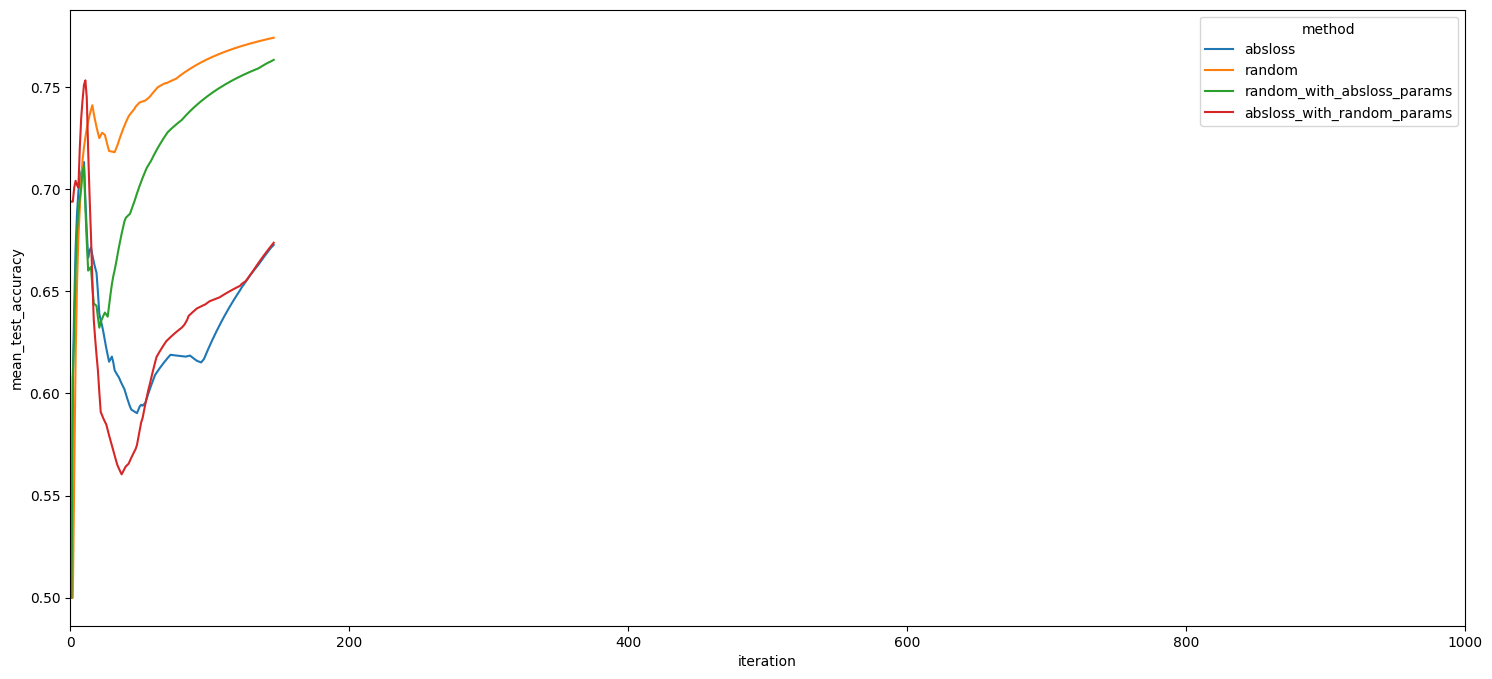

In [25]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

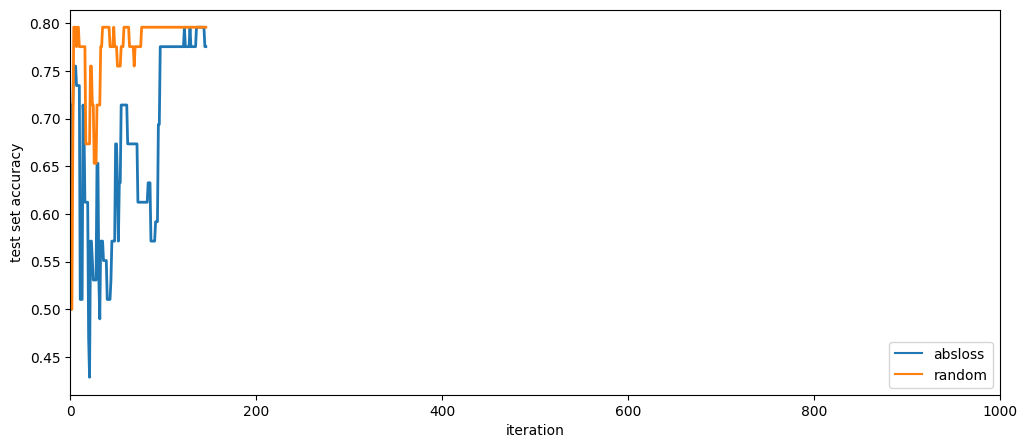

In [26]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig(f"figure_8a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

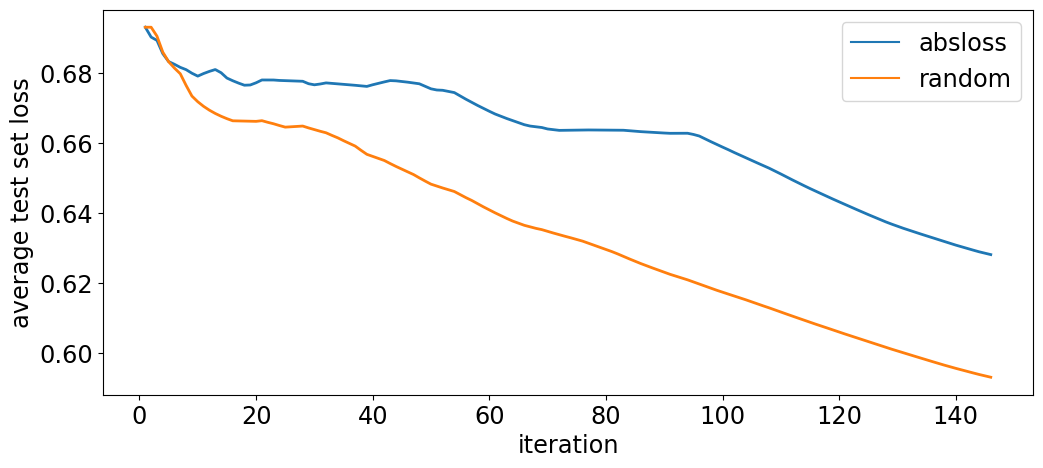

In [27]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_7a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

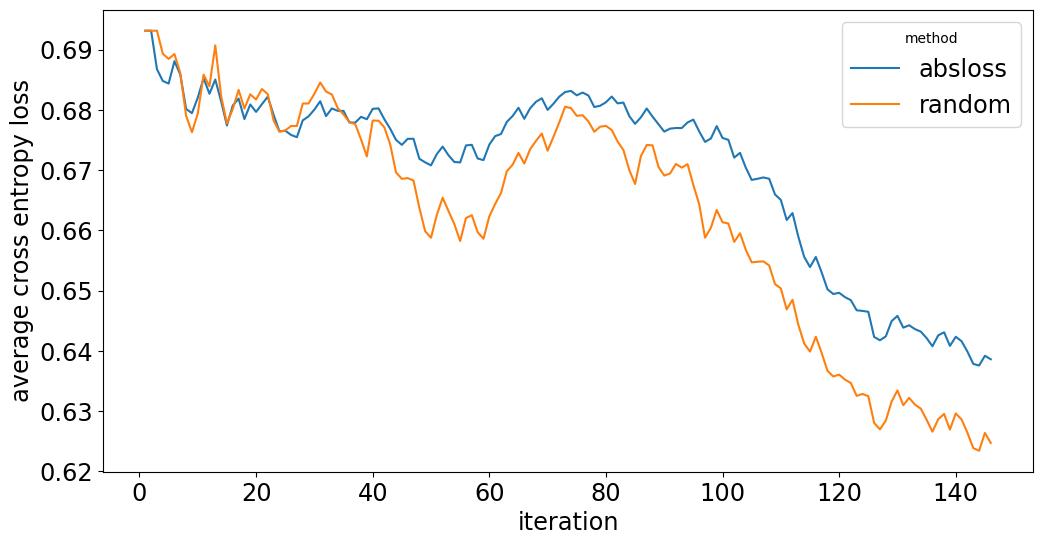

In [28]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

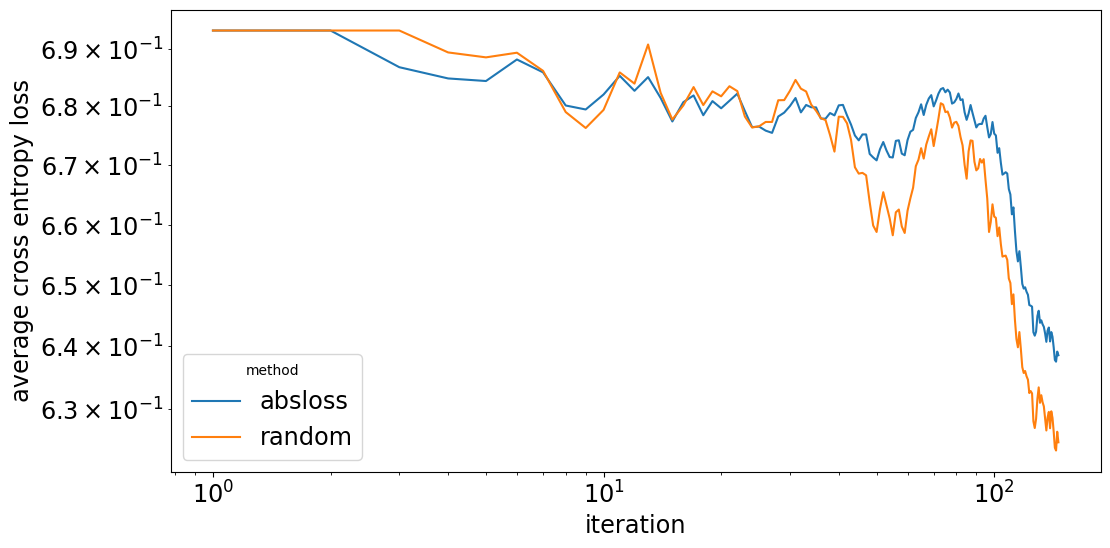

In [29]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [30]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 146 iterations with d=22
loss: 0.6823752871154962, train loss: 0.6931471805599453, ||theta||_1: 0.06810653197443732 acc: 0.5
loss: 0.6598099061946769, train loss: 0.7733862225012156, ||theta||_1: 0.20241804731998722 acc: 0.0
loss: 0.6984853810002083, train loss: 0.712897588177804, ||theta||_1: 0.2671539466293927 acc: 0.0
loss: 0.7184352084652877, train loss: 0.6186217472982208, ||theta||_1: 0.4392049892315245 acc: 1.0
loss: 0.6629253662637127, train loss: 0.6939945177442264, ||theta||_1: 0.3224795965138619 acc: 0.0
loss: 0.6086170392391451, train loss: 0.8659116468848967, ||theta||_1: 0.5341317963720837 acc: 0.0
loss: 0.6044695256690418, train loss: 0.742382361705632, ||theta||_1: 0.5483618258468781 acc: 0.0
loss: 0.6372440077641396, train loss: 0.7431768584167495, ||theta||_1: 0.5382662425861644 acc: 0.0
loss: 0.6304257382103898, train loss: 0.7451824061691614, ||theta||_1: 0.5222054741984552 acc: 0.0
loss: 0.6240182158127464, train loss: 0.754

In [31]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[19.483242375545924, 9.741621187772962, 5.8650403678308844, 2.9325201839154422]

In [32]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [33]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [34]:
empirical_pzs

[0.0825047445715242,
 0.2682436160873062,
 0.4218535911438627,
 0.5723638974782779]

In [35]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [36]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [37]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs       
polyak_exponent  19.5        3.344347e-27    1.711520
                             3.248076e-25    2.459543
                             2.793364e-17    1.146919
                             7.593212e-17    1.238526
                             4.736778e-16    0.932173
                                               ...   
                 9.7         3.583009e-01    0.574296
random           19.5        8.250474e-02    0.687995
                 2.9         5.723639e-01    0.627363
                 5.9         4.218536e-01    0.649344
                 9.7         2.682436e-01    0.648414
Name: train_loss, Length: 191, dtype: float64

In [38]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs       
polyak_exponent  19.5        3.344347e-27    0.723017
                             3.248076e-25    0.738522
                             2.793364e-17    0.725075
                             7.593212e-17    0.740032
                             4.736778e-16    0.701536
                                               ...   
                 9.7         3.583009e-01    0.596815
random           19.5        8.250474e-02    0.684810
                 2.9         5.723639e-01    0.626262
                 5.9         4.218536e-01    0.648595
                 9.7         2.682436e-01    0.647880
Name: mean_train_loss, Length: 191, dtype: float64

Polyak exp value 19.5 has rows (292, 16)
Polyak exp value 9.7 has rows (292, 16)
Polyak exp value 5.9 has rows (292, 16)
Polyak exp value 2.9 has rows (292, 16)


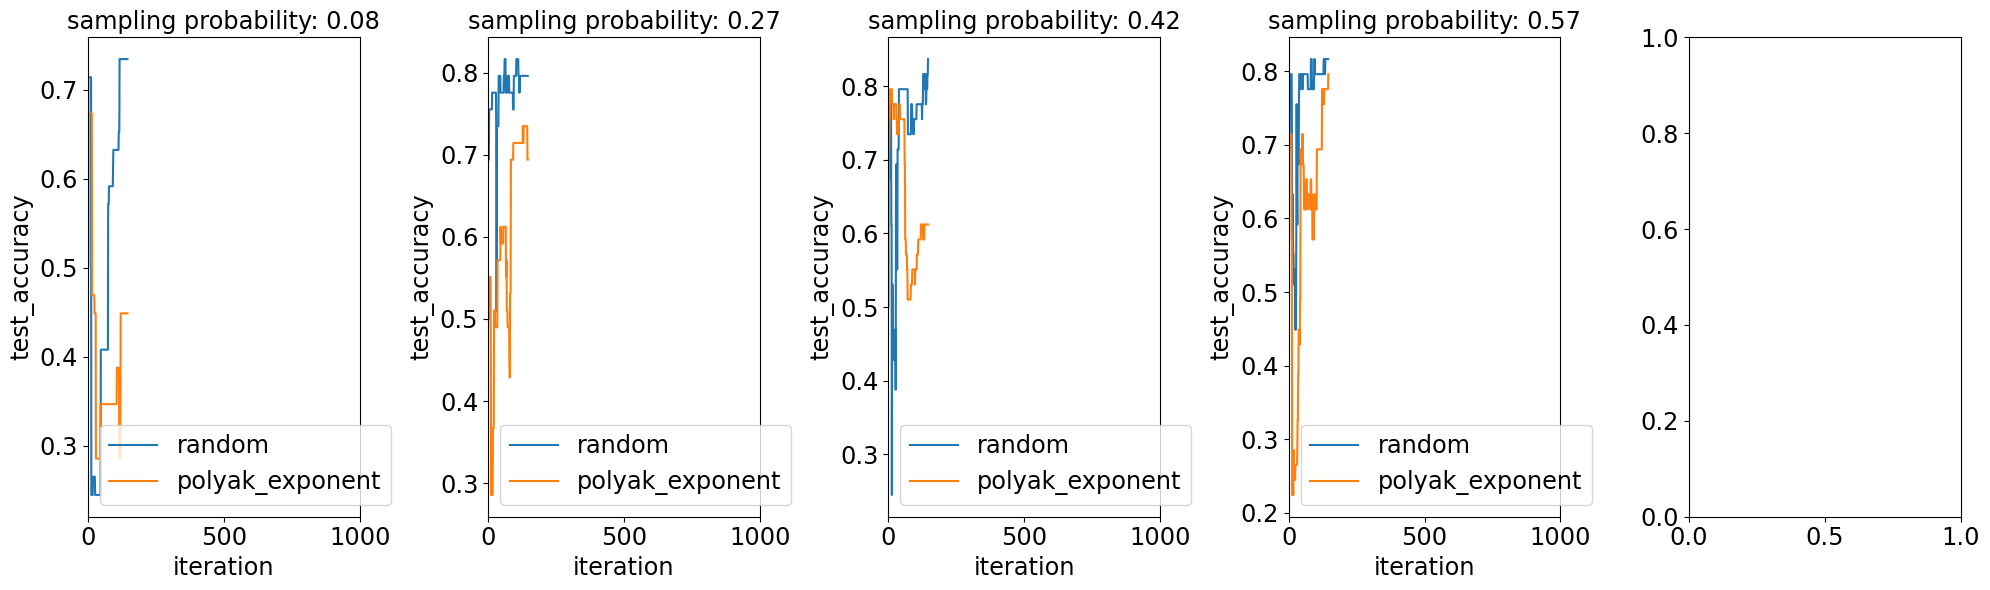

In [39]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 19.5 has rows (292, 16)
Polyak exp value 9.7 has rows (292, 16)
Polyak exp value 5.9 has rows (292, 16)
Polyak exp value 2.9 has rows (292, 16)


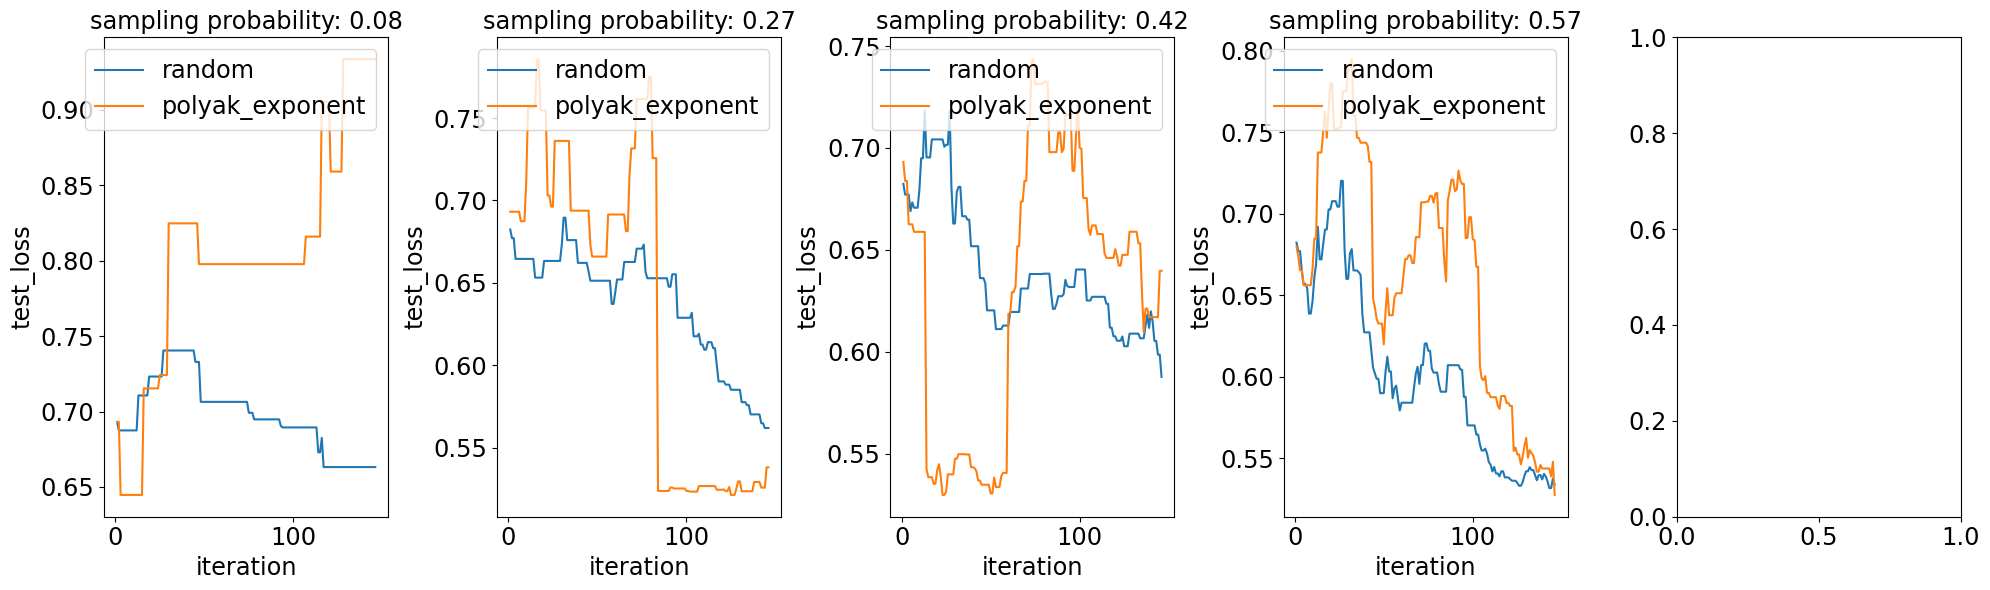

In [40]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [41]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

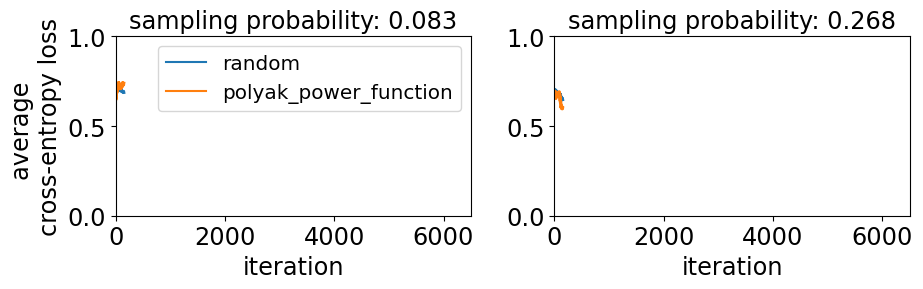

In [42]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

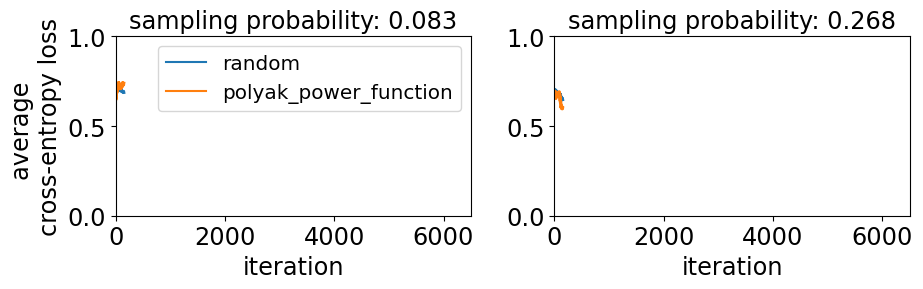

In [43]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

0.0825047445715242
Polyak exp value 19.5 has rows (292, 16)
0.2682436160873062
Polyak exp value 9.7 has rows (292, 16)
0.4218535911438627
Polyak exp value 5.9 has rows (292, 16)
0.5723638974782779
Polyak exp value 2.9 has rows (292, 16)


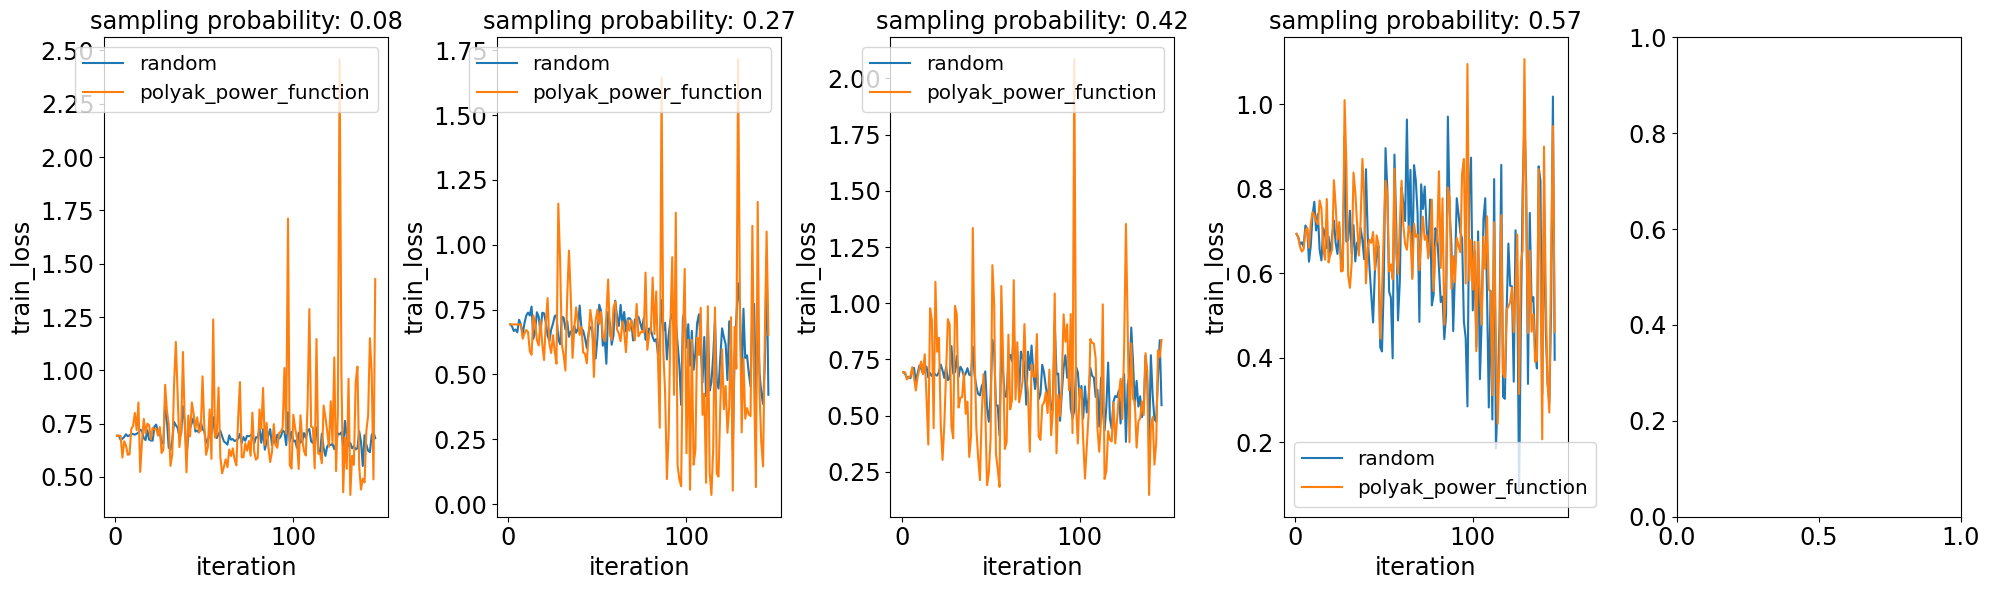

In [44]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.0825047445715242
Polyak exp value 19.5 has rows (292, 16)
0.2682436160873062
Polyak exp value 9.7 has rows (292, 16)
0.4218535911438627
Polyak exp value 5.9 has rows (292, 16)
0.5723638974782779
Polyak exp value 2.9 has rows (292, 16)


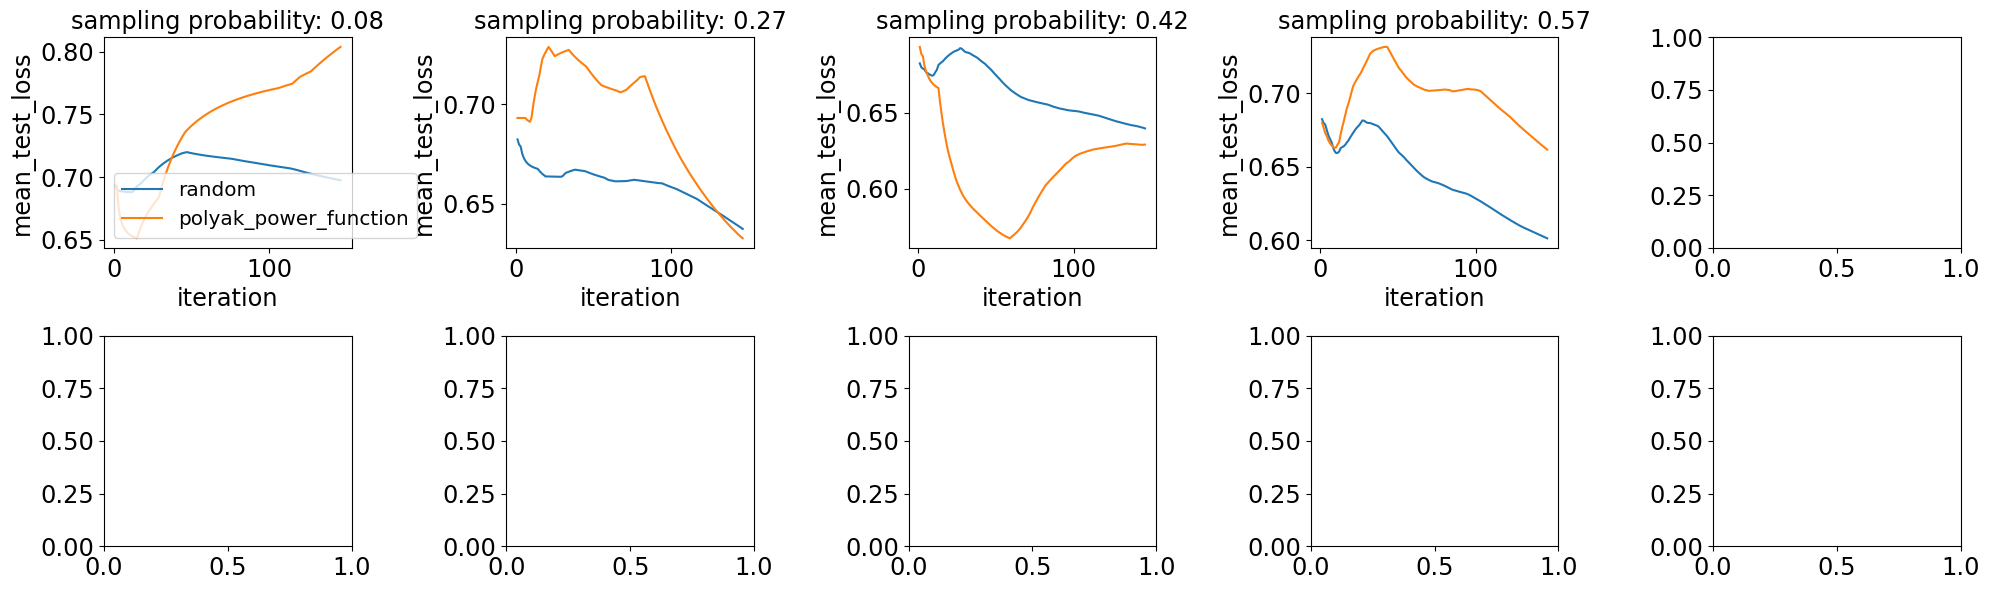

In [45]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [46]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 5, 'kappa0': 0.9, 'eta': 0.01, 'omega': 1.0}

In [47]:
results_polyak_random = train_model(
    X, y, Xtest, ytest, mode="polyak_random", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"] | {"pz0": absloss_mean_sampling_prob}
)

Training with algorithm polyak_random: 146 iterations with d=22
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.7085353909191587, train loss: 0.7281503373944901, ||theta||_1: 0.22837176933297684 acc: 0.0
loss: 0.7838242529773941, train loss: 0.6794732908170287, ||theta||_1: 0.47524366185208516 acc: 1.0
loss: 0.782584672744123, train loss: 0.5912719964655415, ||theta||_1: 0.4661781818961098 acc: 1.0
loss: 0.7755494223731855, train loss: 0.6875277466708413, ||theta||_1: 0.5166131116240067 acc: 1.0
loss: 0.7534901414480069, train loss: 0.6365916350326694, ||theta||_1: 0.5076161942921978 acc: 1.0
loss: 0.7463383008791468, train loss: 0.6761900849269256, ||theta||_1: 0.5482324921698593 acc: 1.0
loss: 0.8536289593418351, train loss: 0.5490355270570312, ||theta||_1: 0.8100192326994513 acc: 1.0
loss: 0.8602140541818771, train loss: 1.006801217014097, ||theta||_1: 0.8872035641970945 acc: 0.0
loss: 0.8735321206743496, train loss: 0.6860948424006132, ||

In [48]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 146 iterations with d=22
loss: 0.6931471805599453, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.7129519828181712, train loss: 0.712045948990023, ||theta||_1: 0.185444311569176 acc: 0.0
loss: 0.7181771762073909, train loss: 0.7092136232739336, ||theta||_1: 0.3065435611450765 acc: 0.0
loss: 0.760903443112037, train loss: 0.5947854196767308, ||theta||_1: 0.430393411175541 acc: 1.0
loss: 0.709855680144378, train loss: 0.660684213360024, ||theta||_1: 0.4116116050550011 acc: 1.0
loss: 0.6771897371445399, train loss: 0.7415444679740935, ||theta||_1: 0.45633659480412336 acc: 0.0
loss: 0.6932067789100166, train loss: 0.6983906157054977, ||theta||_1: 0.4652572594585219 acc: 0.0
loss: 0.7504460713175444, train loss: 0.5850074530441419, ||theta||_1: 0.5901645897297332 acc: 1.0
loss: 0.6961723036480947, train loss: 0.8542184168087001, ||theta||_1: 0.5319610350453757 acc: 0.0
loss: 0.672070663170802, train loss: 0.7316731892017345, ||theta

In [49]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 5, 'kappa0': 0.9, 'eta': 0.01, 'omega': 0.9619047342176554}


In [50]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

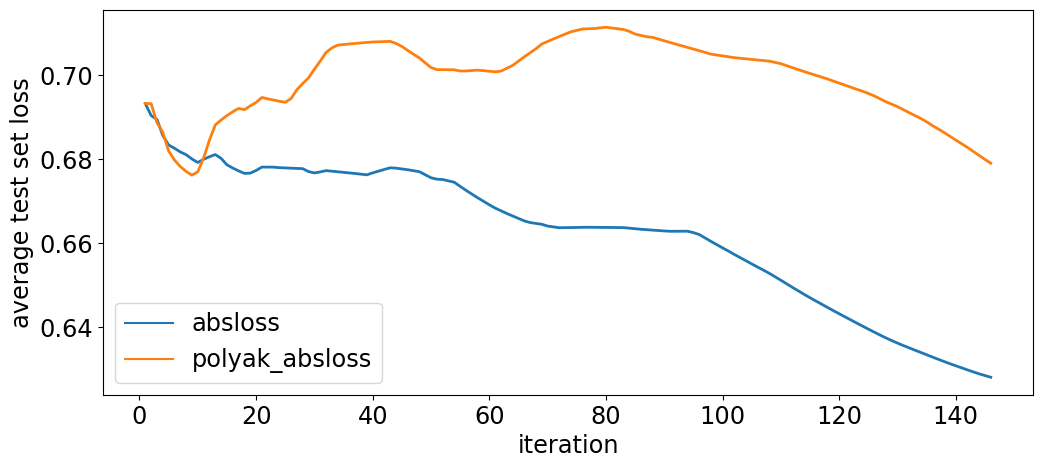

In [51]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig(f"figure_7b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

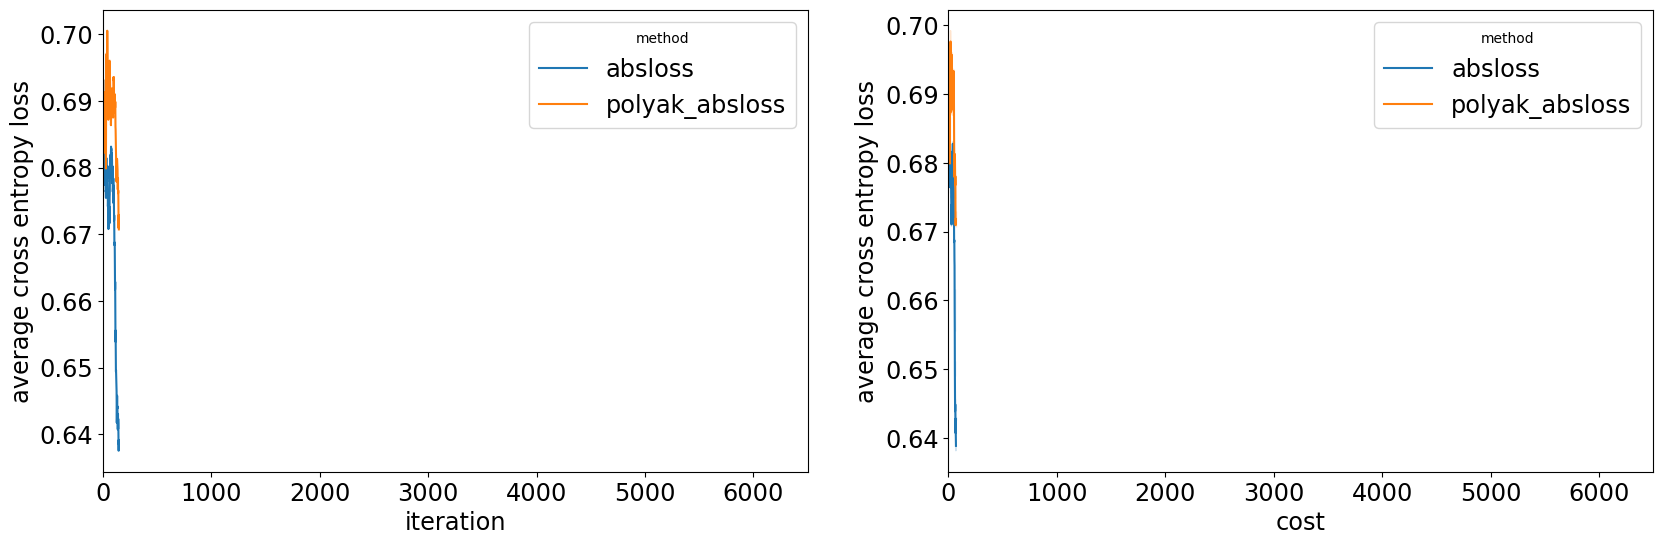

In [52]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

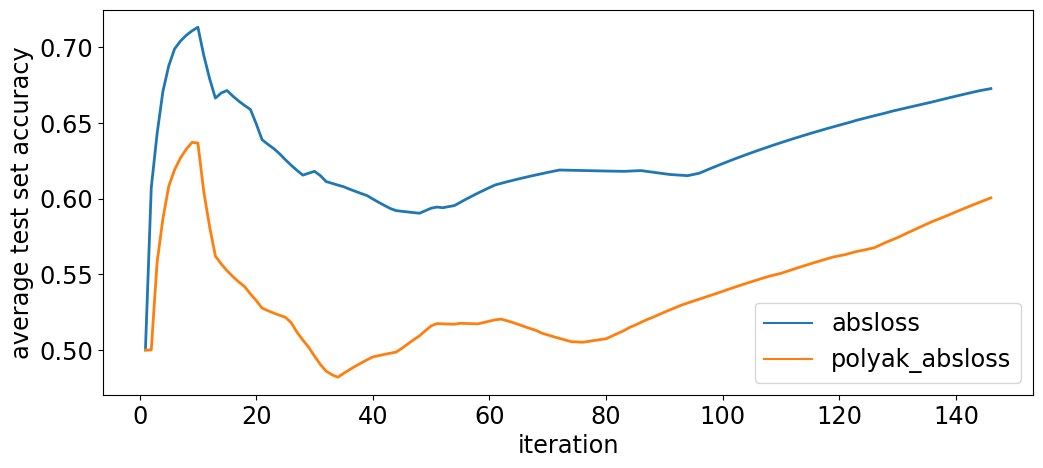

In [53]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_8b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

In [54]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
        "polyak_random": results_polyak_random
    }
)

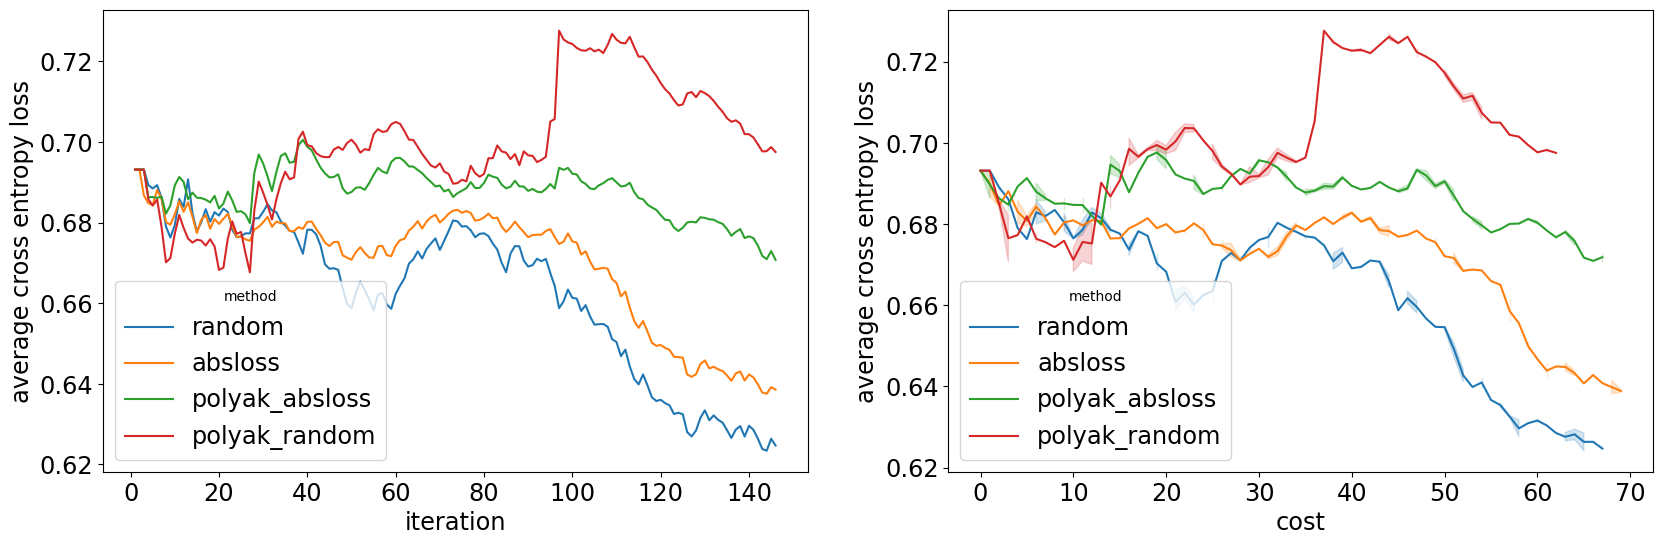

In [55]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

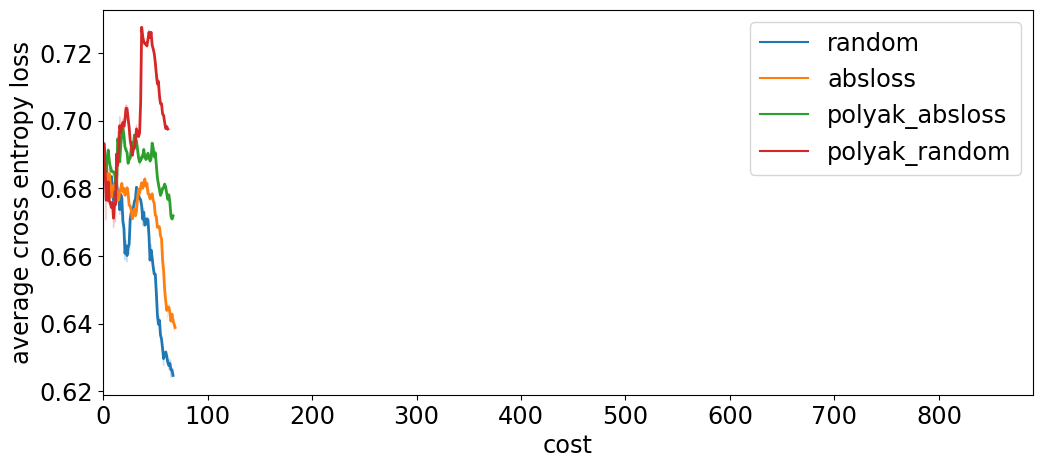

In [56]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_6_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

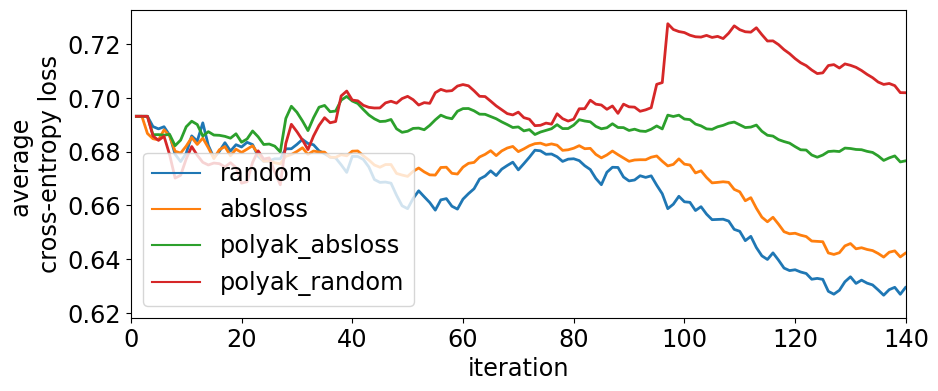

In [57]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')
ax.set_xlim((0, 140))

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig(f"figure_3_icml_{dataset_name}_3.pdf", format="pdf", bbox_inches="tight")
